**Download dataset**

In [ ]:
!mkdir /var/colab/dataset
%cd /var/colab/dataset
!curl -L -o archive.zip\
https://www.kaggle.com/api/v1/datasets/download/vencerlanz09/sea-animals-image-dataste
!unzip archive.zip
!rm archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Seahorse/9891995103_849905035f_o.jpg  
  inflating: Seahorse/9984393_fb8ac77d6a_o.jpg  
  inflating: Seahorse/Sea Horse (1).jpg  
  inflating: Seahorse/Sea Horse (10).jpg  
  inflating: Seahorse/Sea Horse (11).jpg  
  inflating: Seahorse/Sea Horse (12).jpg  
  inflating: Seahorse/Sea Horse (13).jpg  
  inflating: Seahorse/Sea Horse (14).jpg  
  inflating: Seahorse/Sea Horse (15).jpg  
  inflating: Seahorse/Sea Horse (16).jpg  
  inflating: Seahorse/Sea Horse (17).jpg  
  inflating: Seahorse/Sea Horse (18).jpg  
  inflating: Seahorse/Sea Horse (19).jpg  
  inflating: Seahorse/Sea Horse (2).jpg  
  inflating: Seahorse/Sea Horse (20).jpg  
  inflating: Seahorse/Sea Horse (21).jpg  
  inflating: Seahorse/Sea Horse (22).jpg  
  inflating: Seahorse/Sea Horse (23).jpg  
  inflating: Seahorse/Sea Horse (24).jpg  
  inflating: Seahorse/Sea Horse (25).jpg  
  inflating: Seahorse/Sea Horse (26).jpg  
  inflating: Seahorse/Sea Horse (

**Import required modules**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight

**Setup TPU**

In [ ]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Running on TPU:", resolver.cluster_spec().as_dict())
except ValueError:
    strategy = tf.distribute.get_strategy()
print(f"Running on {strategy.num_replicas_in_sync} replicas")

Running on 1 replicas


**Augmentation**

In [ ]:
# Define random data augmentation layers
augmentation_layers = [
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomFlip("horizontal"),
]

# Function to apply augmentation
def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

# Function to wrap data augmentation and label
@tf.autograph.experimental.do_not_convert
def augment_data(x, y):
    return data_augmentation(x), y

**Create datasets for training and validation**

In [ ]:
dataset_dir = "/var/colab/dataset"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=128
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=128
)

class_names = train_ds.class_names

# Apply augmentation to the training set
train_ds = train_ds.map(augment_data)

# Preprocess the dataset with ResNet preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
validation_ds = validation_ds.map(lambda x, y: (preprocess_input(x), y))

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")

Found 13711 files belonging to 23 classes.
Using 10969 files for training.
Found 13711 files belonging to 23 classes.
Using 2742 files for validation.
Number of training samples: 86
Number of validation samples: 22


**Save labels**

In [ ]:
with open('labels.txt','w') as f:
    for label in class_names:
        f.write(f'{label}\n')

**Create Model**

In [ ]:
# Create model within TPU strategy scope
with strategy.scope():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    base_model = tf.keras.applications.ResNet50V2(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False,
        pooling='max'
    )
    base_model.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    x = base_model(inputs, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


**Model Summary**

In [ ]:
model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ resnet50v2 (Functional)             │ (None, 2048)                 │    23,564,800 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 256)                  │       524,544 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization                 │ (None, 256)                  │         1,024 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 256)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_1 (Dense)                     │ (None, 128)                  │        32,896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_1               │ (None, 128)                  │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 23)                   │         2,967 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 24,126,743 (92.04 MB)

 Trainable params: 8,440,855 (32.20 MB)

 Non-trainable params: 15,685,888 (59.84 MB)

In [ ]:
# Access class names from the original training dataset before any transformations
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=128
)
class_names = train_ds_raw.class_names  # Get class names before transformations

# Extract labels by iterating through the original dataset
labels = np.concatenate([y for x, y in train_ds_raw], axis=0)

# Calculate class weights based on label distribution
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

Found 13711 files belonging to 23 classes.
Using 10969 files for training.


**Training**

In [ ]:
epochs = 20
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.8, patience=3, mode='min'
        )
    ]
)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.3264 - loss: 2.6216 - val_accuracy: 0.6025 - val_loss: 1.8048 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.6425 - loss: 1.2782 - val_accuracy: 0.7166 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.7286 - loss: 1.0043 - val_accuracy: 0.7491 - val_loss: 0.9175 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.7667 - loss: 0.8575 - val_accuracy: 0.7724 - val_loss: 0.8524 - learning_rate: 0.0010
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.7934 - loss: 0.7610 - val_accuracy: 0.7819 - val_loss: 0.7893 - learning_rate: 0.0010
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8231 - loss: 0.6471 - val_accuracy: 0.7728 - val_loss: 0.8438 - learning_rate: 0.0010
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.8480 - loss: 0.5698 - val_acc

**Save the model**

In [ ]:
model.save("model.keras")

**Test**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

class_names = []

with open('labels.txt','r') as f:
    for line in f:
        class_names.append(line.strip())

model = tf.keras.models.load_model('model.keras')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resizing image to the input shape
    img_array = image.img_to_array(img)  # Convert the image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)  # Preprocess for ResNet
    return img_array

def classify(img_path):
    input_image = preprocess_image(img_path)
    predictions = model.predict(input_image)
    predicted_class = np.argmax(predictions, axis=1)
    confidence = np.max(predictions, axis=1)
    print(f"Predicted class: {class_names[predicted_class[0]]}")
    print(f"Confidence: {confidence[0]:.2f}")

--2024-11-14 08:07:15--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQnTt4kKGSNkQ9gq47pXqAsFoIT2CthNR_YXfboQOoZCmHhDg8OcD-urc_4i95PqNgXkFo&usqp=CAU
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.253.118.138, 172.253.118.101, 172.253.118.139, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.253.118.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7558 (7.4K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   7.38K  --.-KB/s    in 0s      

2024-11-14 08:07:15 (133 MB/s) - ‘test.jpg’ saved [7558/7558]



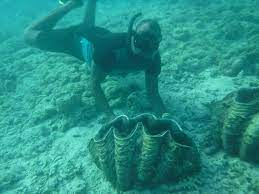

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class: Clams
Confidence: 0.99


In [ ]:
from PIL import Image
import IPython.display as display

#image of giant clam discovered by a diver taken at great depth with significant clarity loss
!wget 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQnTt4kKGSNkQ9gq47pXqAsFoIT2CthNR_YXfboQOoZCmHhDg8OcD-urc_4i95PqNgXkFo&usqp=CAU' -O test.jpg

img = Image.open('test.jpg')
display.display(img)

classify("test.jpg")